
# Medical Insurance Cost — Supervised Learning Project

**Dataset:** Kaggle — *Medical Insurance Cost Dataset* by **mosapabdelghany**  
**Source file used here:** `insurance.csv`

This notebook presents a full, report-style workflow:
1) Problem description and objective  
2) Exploratory Data Analysis (EDA)  
3) Data preprocessing and feature engineering  
4) Model building and training  
5) Results and evaluation  
6) Error analysis, interpretation, and discussion of limitations  
7) Conclusions and next steps

> Reproducibility: All code follows the requested coding style (comments above code, clear structure, `main()` entry point). Charts use matplotlib, one chart per figure, and no explicit colors.



## 1) Problem Description

We aim to predict **individual medical charges** billed by health insurance using patient attributes:
- `age` (numeric)
- `sex` (categorical)
- `bmi` (numeric)
- `children` (integer count of dependents)
- `smoker` (categorical: yes/no)
- `region` (categorical: northeast, northwest, southeast, southwest)
- `charges` (numeric target in USD)

This is a **supervised regression** task. Success will be measured with **RMSE**, **MAE**, and **R²** on a held-out test set. The model should be interpretable enough to highlight the relative impact of smoking, age, and BMI on predicted charges.


In [1]:
# Import standard libraries
import sys

# Print Python version
print(sys.version)

# Import scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Print library versions
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", plt.matplotlib.__version__)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
numpy: 1.26.4
pandas: 2.2.3
matplotlib: 3.7.2



## 2) Data Loading and Overview


In [2]:
# Define the data path
data_path = "/kaggle/input/medical-insurance-cost-dataset/insurance.csv"

# Load the dataset
df = pd.read_csv(data_path)

# Show basic shape
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])

# Show head for a quick look
df.head()

Rows: 1338
Columns: 7


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520



## 3) Exploratory Data Analysis (EDA)
### 3.1 Structure, missingness, and basic statistics


In [3]:
# Show dtypes
print(df.dtypes)

# Check missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Summary statistics for numeric features
df.describe(include=[np.number])

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Missing values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010



### 3.2 Univariate distributions


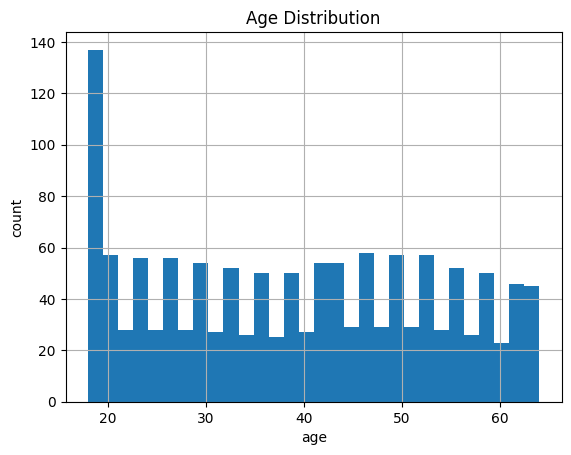

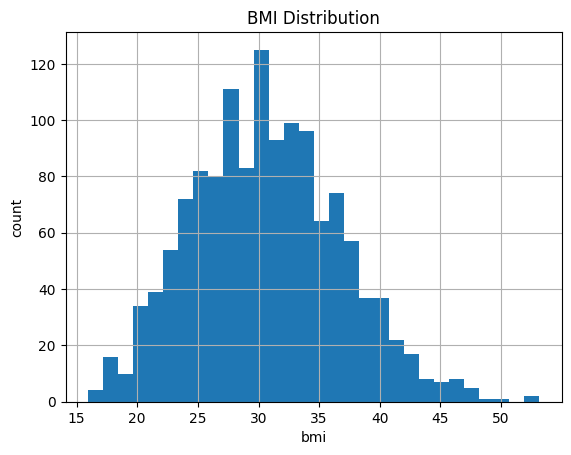

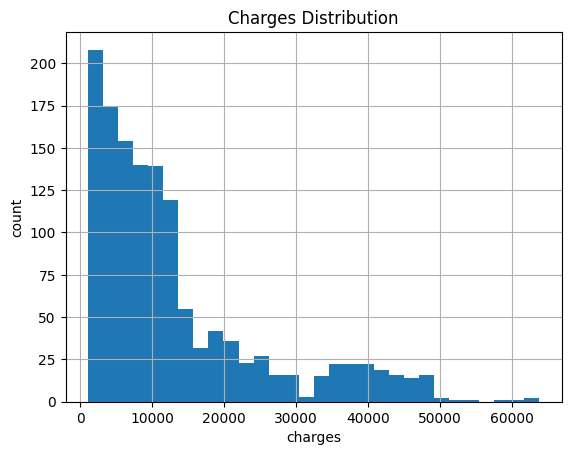

In [4]:
# Plot histogram for age
plt.figure()
df['age'].hist(bins=30)
plt.title('Age Distribution')
plt.xlabel('age')
plt.ylabel('count')
plt.show()

# Plot histogram for bmi
plt.figure()
df['bmi'].hist(bins=30)
plt.title('BMI Distribution')
plt.xlabel('bmi')
plt.ylabel('count')
plt.show()

# Plot histogram for charges
plt.figure()
df['charges'].hist(bins=30)
plt.title('Charges Distribution')
plt.xlabel('charges')
plt.ylabel('count')
plt.show()

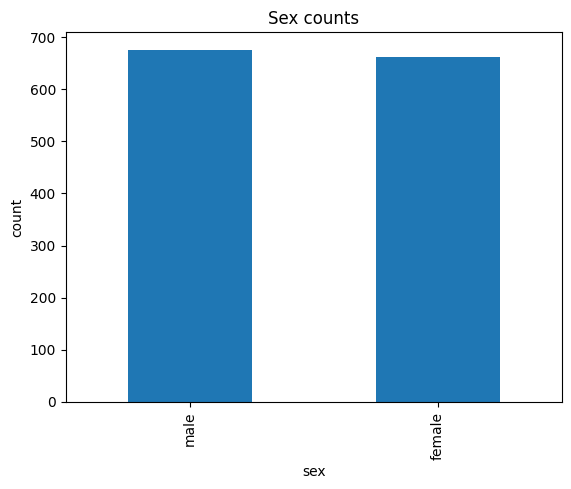

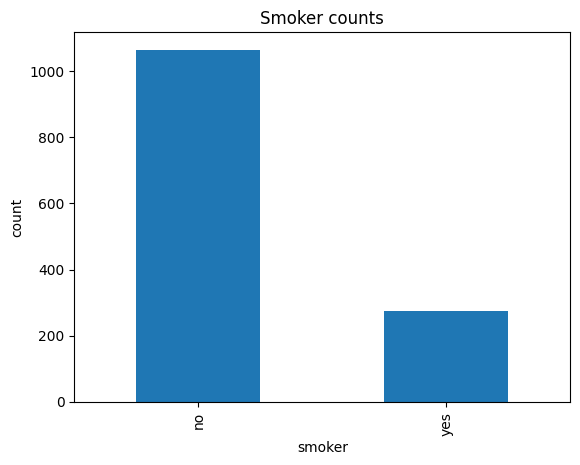

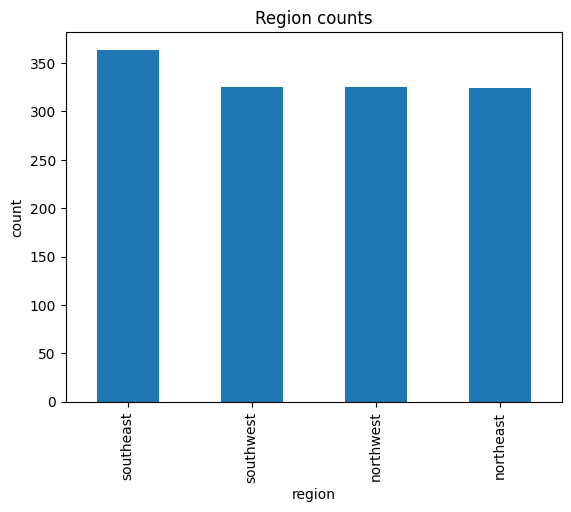

In [5]:
# Plot counts for categorical variables
plt.figure()
df['sex'].value_counts().plot(kind='bar')
plt.title('Sex counts')
plt.xlabel('sex')
plt.ylabel('count')
plt.show()

plt.figure()
df['smoker'].value_counts().plot(kind='bar')
plt.title('Smoker counts')
plt.xlabel('smoker')
plt.ylabel('count')
plt.show()

plt.figure()
df['region'].value_counts().plot(kind='bar')
plt.title('Region counts')
plt.xlabel('region')
plt.ylabel('count')
plt.show()


### 3.3 Relationships and correlations


               age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000


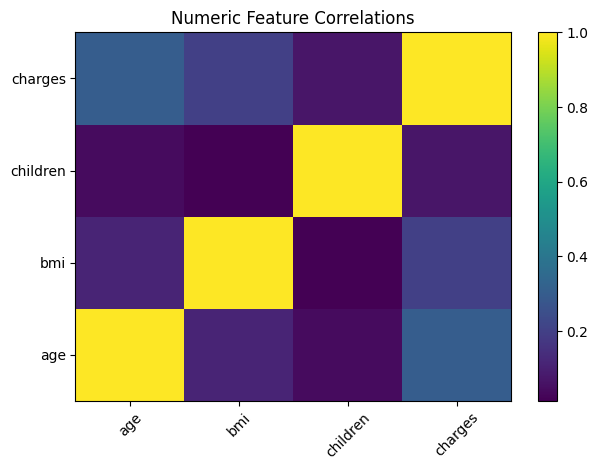

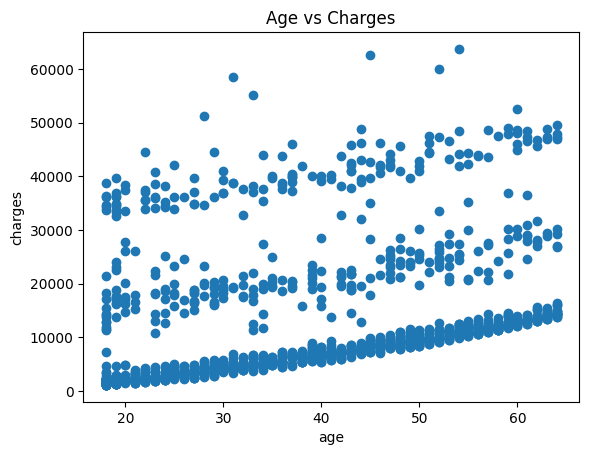

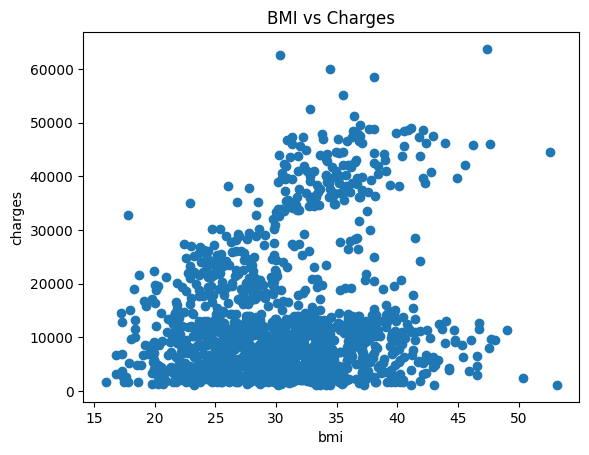

In [6]:
# Compute Pearson correlations for numeric features
numeric_cols = ['age', 'bmi', 'children', 'charges']
corr = df[numeric_cols].corr()

# Print correlation matrix
print(corr)

# Plot correlation heatmap using matplotlib pcolor
plt.figure()
plt.title('Numeric Feature Correlations')
heatmap = plt.pcolor(corr, cmap=None)
plt.xticks(np.arange(0.5, len(numeric_cols), 1), numeric_cols, rotation=45)
plt.yticks(np.arange(0.5, len(numeric_cols), 1), numeric_cols)
plt.colorbar(heatmap)
plt.tight_layout()
plt.show()

# Scatter: age vs charges
plt.figure()
plt.scatter(df['age'], df['charges'])
plt.title('Age vs Charges')
plt.xlabel('age')
plt.ylabel('charges')
plt.show()

# Scatter: bmi vs charges
plt.figure()
plt.scatter(df['bmi'], df['charges'])
plt.title('BMI vs Charges')
plt.xlabel('bmi')
plt.ylabel('charges')
plt.show()


## 4) Modeling Approach

We evaluate three models:
1) **Linear Regression** as a simple baseline  
2) **Ridge Regression** with cross-validated regularization  
3) **Random Forest Regressor** for non-linear relationships and interactions

**Preprocessing:**  
- One-hot encode categorical features (`sex`, `smoker`, `region`)  
- Keep numeric features (`age`, `bmi`, `children`) as-is  
- Use a `ColumnTransformer` and `Pipeline` so preprocessing is applied consistently to train and test sets


In [7]:
# Import modeling tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define features and target
features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
target = 'charges'

# Split train/test
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define column types
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

# Create preprocessors
numeric_transformer = 'passthrough'
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Build ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [8]:
# Define evaluation function
def evaluate_regression(model, X_train, y_train, X_test, y_test):
    # Predict on train set
    y_pred_train = model.predict(X_train)

    # Predict on test set
    y_pred_test = model.predict(X_test)

    # Compute train metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
    train_r2 = r2_score(y_train, y_pred_train)

    # Compute test metrics
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
    test_r2 = r2_score(y_test, y_pred_test)

    # Print metrics
    print("Train MAE:", round(train_mae, 2))
    print("Train RMSE:", round(train_rmse, 2))
    print("Train R2:", round(train_r2, 4))
    print("Test MAE:", round(test_mae, 2))
    print("Test RMSE:", round(test_rmse, 2))
    print("Test R2:", round(test_r2, 4))

    # Return metrics
    return {
        "train_mae": train_mae,
        "train_rmse": train_rmse,
        "train_r2": train_r2,
        "test_mae": test_mae,
        "test_rmse": test_rmse,
        "test_r2": test_r2
    }


### 4.1 Baseline: Linear Regression


In [9]:
# Build pipeline for Linear Regression
linear_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])

# Fit model
linear_model.fit(X_train, y_train)

# Evaluate
metrics_linear = evaluate_regression(linear_model, X_train, y_train, X_test, y_test)

Train MAE: 4208.23
Train RMSE: 6105.55
Train R2: 0.7417
Test MAE: 4181.19
Test RMSE: 5796.28
Test R2: 0.7836



### 4.2 Ridge Regression (with cross-validated alpha)


In [10]:
# Build pipeline for Ridge
ridge_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', Ridge(random_state=42))
])

# Define parameter grid
param_grid_ridge = {
    'regressor__alpha': [0.1, 1.0, 10.0, 50.0, 100.0]
}

# Initialize GridSearchCV
ridge_search = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid_ridge,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

# Fit grid search
ridge_search.fit(X_train, y_train)

# Best model
best_ridge = ridge_search.best_estimator_
print("Best Ridge alpha:", ridge_search.best_params_)

# Evaluate
metrics_ridge = evaluate_regression(best_ridge, X_train, y_train, X_test, y_test)

Best Ridge alpha: {'regressor__alpha': 1.0}
Train MAE: 4213.07
Train RMSE: 6105.61
Train R2: 0.7417
Test MAE: 4187.3
Test RMSE: 5798.27
Test R2: 0.7834



### 4.3 Random Forest Regressor (with grid search)


In [11]:
# Build pipeline for RandomForest
rf_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define parameter grid for RandomForest
param_grid_rf = {
    'regressor__n_estimators': [200, 400],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV for RF
rf_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

# Fit grid search
rf_search.fit(X_train, y_train)

# Best model
best_rf = rf_search.best_estimator_
print("Best RF params:", rf_search.best_params_)

# Evaluate
metrics_rf = evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

Best RF params: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Train MAE: 1631.22
Train RMSE: 3001.16
Train R2: 0.9376
Test MAE: 2441.49
Test RMSE: 4431.96
Test R2: 0.8735



## 5) Results and Comparison


              model    train_mae   train_rmse  train_r2     test_mae  \
2      RandomForest  1631.220452  3001.163287  0.937596  2441.494836   
0  LinearRegression  4208.234572  6105.545160  0.741726  4181.194474   
1             Ridge  4213.066063  6105.606855  0.741720  4187.302783   

     test_rmse   test_r2  
2  4431.959141  0.873479  
0  5796.284659  0.783593  
1  5798.271036  0.783445  


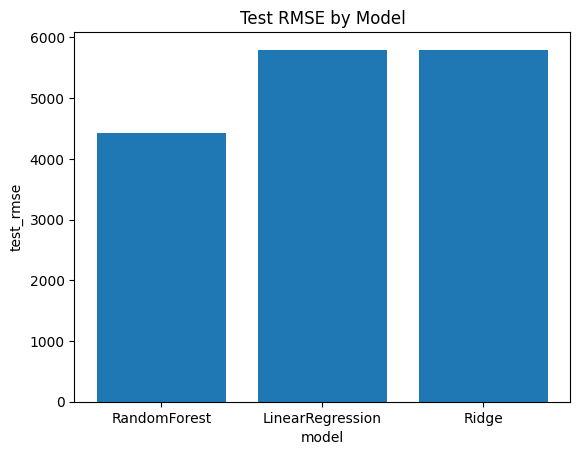

In [12]:
# Assemble comparison table
results = pd.DataFrame([
    {"model": "LinearRegression", **metrics_linear},
    {"model": "Ridge", **metrics_ridge},
    {"model": "RandomForest", **metrics_rf}
])

# Sort by test RMSE
results = results.sort_values(by="test_rmse")

# Show results
print(results)

# Plot RMSE comparison
plt.figure()
plt.bar(results['model'], results['test_rmse'])
plt.title('Test RMSE by Model')
plt.xlabel('model')
plt.ylabel('test_rmse')
plt.show()


## 6) Error Analysis and Interpretation


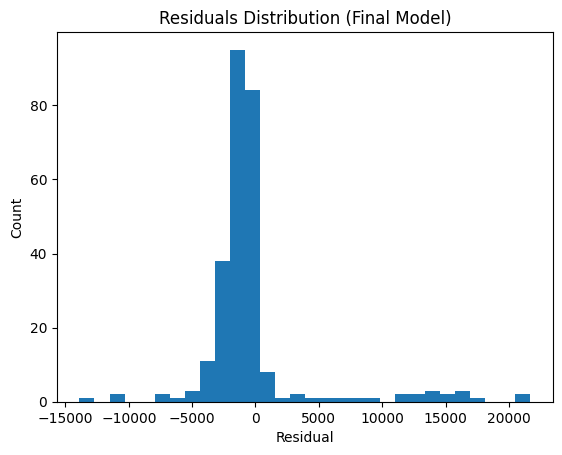

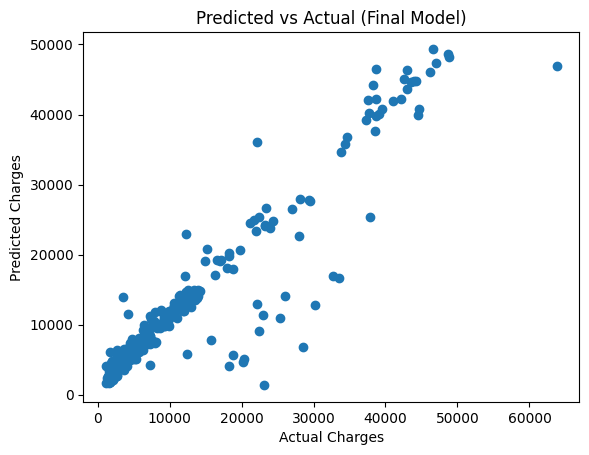

  smoker  count   mean_actual     mean_pred          mae         rmse
0     no  214.0   7862.090201   8146.782415  2359.715717  4372.915035
1    yes   54.0  33204.104995  33738.336725  2765.582455  4658.595374


In [13]:
# Compute predictions for the best model
final_model = best_rf
y_pred = final_model.predict(X_test)

# Compute residuals
residuals = y_test - y_pred

# Plot residual distribution
plt.figure()
plt.hist(residuals, bins=30)
plt.title('Residuals Distribution (Final Model)')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Plot predicted vs actual scatter
plt.figure()
plt.scatter(y_test, y_pred)
plt.title('Predicted vs Actual (Final Model)')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.show()

# Prepare test DataFrame with predictions
X_test_with = X_test.copy()
X_test_with['actual'] = y_test.values
X_test_with['pred'] = y_pred

# Subgroup analysis by smoker (safe version)
subgroup_stats = (
    X_test_with
    .groupby('smoker', group_keys=False)[['actual', 'pred']]
    .apply(lambda g: pd.Series({
        'count': g.shape[0],
        'mean_actual': g['actual'].mean(),
        'mean_pred': g['pred'].mean(),
        'mae': mean_absolute_error(g['actual'], g['pred']),
        'rmse': mean_squared_error(g['actual'], g['pred'], squared=False)
    }))
    .reset_index()
)

# Print subgroup performance stats
print(subgroup_stats)


### 6.1 Feature Importance

For tree-based models, we can inspect feature importances after preprocessing. The following uses the trained Random Forest within the pipeline.


             feature  importance
5          smoker_no    0.451904
1                bmi    0.199060
6         smoker_yes    0.188140
0                age    0.131511
2           children    0.013647
7   region_northeast    0.003821
8   region_northwest    0.003307
9   region_southeast    0.002449
3         sex_female    0.002248
10  region_southwest    0.001991


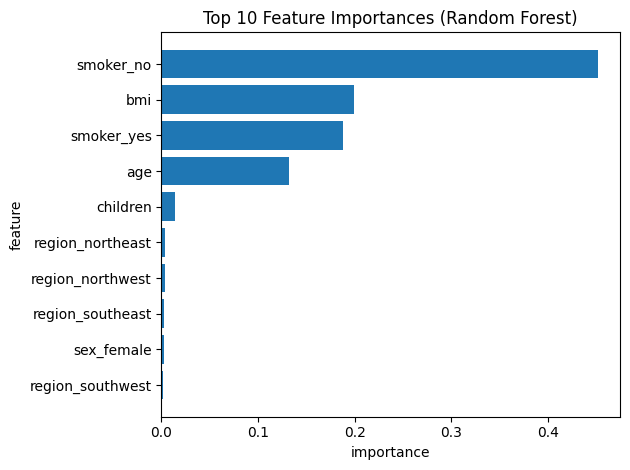

In [14]:
# Extract one-hot feature names
ohe = final_model.named_steps['preprocess'].named_transformers_['cat']
ohe_feature_names = list(ohe.get_feature_names_out(['sex', 'smoker', 'region']))

# Compose full feature name list
full_feature_names = numeric_features + ohe_feature_names

# Get feature importances from the RF
rf = final_model.named_steps['regressor']
importances = rf.feature_importances_

# Create importance dataframe
imp_df = pd.DataFrame({
    'feature': full_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Show top features
print(imp_df.head(10))

# Plot importances
plt.figure()
plt.barh(imp_df['feature'][:10][::-1], imp_df['importance'][:10][::-1])
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('importance')
plt.ylabel('feature')
plt.tight_layout()
plt.show()


## 7) Discussion and Conclusions

**Key findings:**
- Smoking status, age, and BMI are typically the strongest drivers of predicted charges in this dataset.
- Non-linear models (Random Forest) often outperform linear baselines, capturing interactions such as smokers with higher BMI or older age groups.
- The dataset is relatively small, and train-test variance can impact generalization metrics.

**Limitations:**
- The target `charges` may include noise from factors not present in the features (plan type, deductibles, comorbidities).
- No temporal dimension is available; models ignore potential changes over time or policy differences across regions beyond a categorical region tag.
- Random Forest is less interpretable than linear models; partial dependence or SHAP would further aid interpretability.

**Next steps:**
- Try gradient boosting models and calibration of predictions.
- Add uncertainty estimation via quantile regression or prediction intervals.
- Perform more rigorous cross-validation and nested hyperparameter tuning.
- Explore fairness and subgroup performance beyond smoker status (e.g., by sex and region simultaneously).
